In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Prepare data

In [12]:
!cp '/content/drive/MyDrive/deep_learning/train_hq.zip' hq.zip
!cp '/content/drive/MyDrive/deep_learning/train_masks.zip' masks.zip
!unzip -q hq.zip
!unzip -q masks.zip

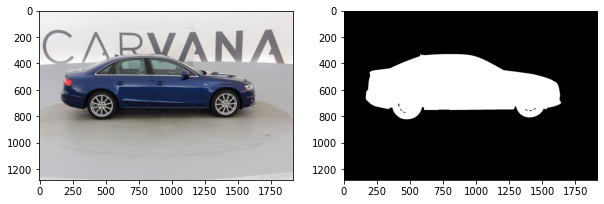

In [13]:
### Visualize the data ###
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline


plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('train_hq/0cdf5b5d0ce1_13.jpg'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('train_masks/0cdf5b5d0ce1_13_mask.gif'))
plt.imshow(mask, 'gray')

plt.show()

In [14]:
import os
import random
import shutil

try:
    path_root_hq = '/content/root_hq/'
    path_root_masks = '/content/root_masks/'
    os.rename('/content/train_hq/', '/content/root_hq/')
    os.rename('/content/train_masks/', '/content/root_masks/')
    path_train_hq = os.path.join('/content/', 'train_hq/')
    path_test_hq = os.path.join('/content/', 'test_hq/')
    path_test_masks = os.path.join('/content/', 'test_masks/')
    path_train_masks = os.path.join('/content/', 'train_masks/')
    os.mkdir(path_train_hq)
    os.mkdir(path_train_masks)
    os.mkdir(path_test_hq)
    os.mkdir(path_test_masks)
except:
    pass

In [15]:
def split_train_test():
    all_files_hq = sorted(os.listdir(path_root_hq))
    all_files_masks = sorted(os.listdir(path_root_masks))
    train_indices = random.sample(range(len(all_files_hq)), int(len(all_files_hq)*0.75))
    test_indices = [x for x in range(len(all_files_hq)) if x not in train_indices]
    for i in train_indices:
        shutil.copy2(path_root_hq + all_files_hq[i], path_train_hq)
        shutil.copy2(path_root_masks + all_files_masks[i], path_train_masks)
    for i in test_indices:
        shutil.copy2(path_root_hq + all_files_hq[i], path_test_hq)
        shutil.copy2(path_root_masks + all_files_masks[i], path_test_masks)

In [16]:
split_train_test()

## Main part

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [31]:
### Target metric ###

def calc_iou(
    prediction: np.array,
    ground_truth: np.array
    ) -> np.array:
    """
    Function for computing IoU metrics.

    Args:
        prediction: batch of binarized predicted masks (either 0 or 1)
        ground_truth: batch of binary GT masks (either 0 or 1)
    Returns:
        calculated iou: np.array
    """
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [32]:
# https://en.wikipedia.org/wiki/Adaptive_histogram_equalization

from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma   
)

In [33]:
from IPython.display import clear_output
import os

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

from torch.nn import Conv2d as Conv2D
import torch.nn.init as init

from torch.nn import Upsample

from PIL import Image

import torchvision.transforms.functional as F
import torch.nn.functional as nnf

In [34]:
#https://github.com/mateuszbuda/brain-segmentation-pytorch/
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 4, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 4, features * 8, name="bottleneck")

        self.upconv2 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 4) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=8, out_channels=out_channels, kernel_size=1
        )
        self.conv_last = nn.Conv2d(features, 8, kernel_size = 3, padding=1)

    def forward(self, x):
        X_resized = nnf.interpolate(x, size = (128, 192))
        enc1 = self.encoder1(X_resized)
        enc2 = self.encoder2(nn.Dropout(p = 0.25)(self.pool1(enc1)))

        bottleneck = self.bottleneck(nn.Dropout(p = 0.5)(self.pool2(enc2)))
        # print(x.shape)
        # print(enc1.shape)
        # print(enc2.shape)
        # print(enc3.shape)
        # print(enc4.shape)
        # print(bottleneck.shape)
        # print(dec4.shape)


        dec2 = self.upconv2(bottleneck)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = nn.Dropout(p = 0.5)(dec2)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec2 = nn.Dropout(p = 0.5)(dec2)
        dec1 = self.decoder1(dec1)
        dec1 = self.conv_last(dec1)
        output = self.conv(dec1)
        output = nnf.interpolate(output, size = (128, 192))
        # print(dec3.shape)
        # print(dec2.shape)

        # print(dec1.shape)
        # print(output.shape)
        return torch.sigmoid(output)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

###get item

In [35]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        root_dir_img,
        root_dir_mask,
        transform
        ):
        super(SegmentationDataset).__init__()
        self.root_dir_img = root_dir_img
        self.root_dir_mask = root_dir_mask
        
        self.files_img = sorted(os.listdir(self.root_dir_img))
        self.files_mask = sorted(os.listdir(self.root_dir_mask))
      
        self.aug = transform
        self.to_tensor = transforms.ToTensor() 
        self.final_transform = transforms.Compose([transforms.ToTensor(),])

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir_img,
                                self.files_img[idx])
        mask_name = os.path.join(self.root_dir_mask,
                                self.files_mask[idx])
      
        pre_img = Image.open(img_name)
        img = np.asarray(pre_img, dtype="uint8")
        pre_mask_ = Image.open(mask_name).convert('L')
        mask_ = np.asarray(pre_mask_, dtype="uint8")
        mask_ = cv2.resize(mask_, dsize = (128, 192)).reshape((128, 192, 1))
        
        if self.aug != None:
            augmented =  self.aug(image=img, mask=mask_)

            return (self.final_transform(augmented['image']), 
                    self.to_tensor(augmented['mask']))
        
        return self.final_transform(img), self.to_tensor(mask_)

    def __len__(self):
        return len(self.files_img)

In [36]:
# pre_img1 = Image.open('/content/test_masks/00087a6bd4dc_01_mask.gif').convert('L')
# img1 = np.asarray(pre_img1, dtype="int32")
# img1 = img1.reshape((1, 1280, 1918))
# plt.imshow(img1.reshape((1280,1918)))
# plt.show()
# plt.imshow(img1.reshape((1280,1918)))
# plt.show()

In [37]:
aug = Compose([
    VerticalFlip(p=0.5),
    OneOf([
        ElasticTransform(
            p=0.5,
            alpha=120,
            sigma=120 * 0.05,
            alpha_affine=120 * 0.03
        ),
        GridDistortion(p=0.5) ], p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.5),    
    RandomGamma(p=0.5)])

In [38]:
transform_val = transforms.Compose([transforms.ToTensor()])

train_data = SegmentationDataset('/content/train_hq', 
                                 '/content/train_masks', 
                                 None)

val_data = SegmentationDataset('/content/test_hq', 
                               '/content/test_masks', 
                               None)

train_loader = DataLoader(train_data, batch_size=1,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=1)

##Go model go!

In [39]:
model = UNet(3,1)
model.cuda()

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [40]:
criterion = nn.BCELoss()

train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []}

In [41]:
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr)
num_epochs = 10

 90%|█████████ | 9/10 [1:03:30<07:01, 421.76s/it]

he


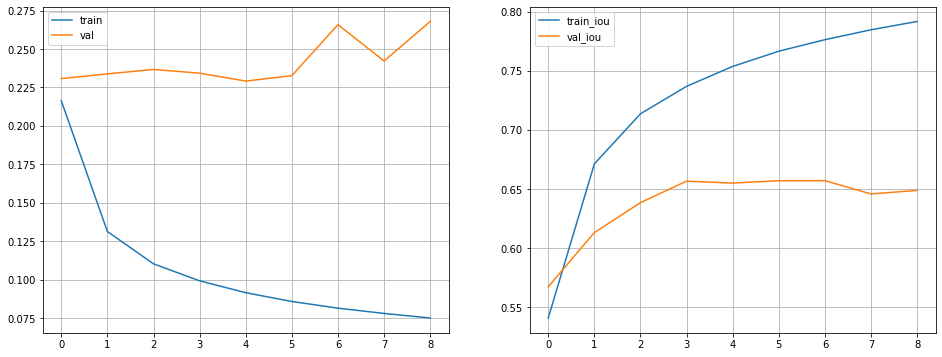

[0.5409116228318394, 0.6712460061547584, 0.7135943774556038, 0.7368250691248797, 0.7536462488041065, 0.7665171228192588, 0.7762505910254802, 0.784649831845219, 0.7916670478812878, 0.7978183967330902]


100%|██████████| 10/10 [1:10:34<00:00, 423.42s/it]


In [42]:
for i in tqdm(range(num_epochs)):
    
    if i>0:
         #print("Epoch %d/%d\t Loss mean: %f\t IoU mean: %f"% \
         #      (i, num_epochs, epoch_loss, epoch_iou))
         #print("Epoch %d/%d\t Val Loss mean: %f\t Val IoU mean: %f"% \
         #      (i, num_epochs, val_loss, val_iou))
         print('he')
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['val_loss'], label='val')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_iou'], label='train_iou')
         plt.plot(hist['val_iou'], label='val_iou')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_ious = []
    val_losses = []
    val_ious = []
    
    model.train()
    for k, (img, mask) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_pred = model(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  mask.numpy())
        epoch_ious.append(iou)
        
        
        #if k%5 == 0:
        #    print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_iou = np.mean(np.array(epoch_ious))
    hist['train_iou'].append(epoch_iou)
    print(hist['train_iou'])
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        model.eval()
        for k, (img, mask) in enumerate(val_loader):
            y_pred = model(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            val_losses.append(loss.item())
            val_ious.append(iou)
            
            
            
    val_loss = np.mean(np.array(val_losses))
    val_iou = np.mean(np.array(val_ious))
    hist['val_loss'].append(val_loss)
    hist['val_iou'].append(val_iou)
    if i < (num_epochs - 1):
        clear_output()
    

##output

In [43]:
pred = model(img.cuda())[0][0].detach().cpu().numpy()

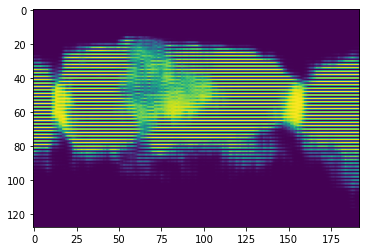

In [48]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((128, 192))])
plt.imshow(torch.squeeze(transform(pred)))

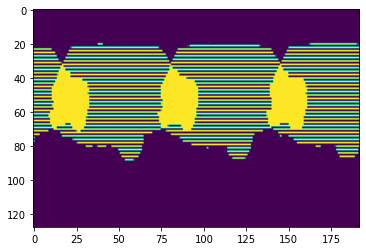

In [47]:
plt.imshow(mask[0].reshape((128,192)))